# Simple forecast of EV Demand in CT (RL Polk Data)

## Set up and clean up files

In [82]:
# DataFrame Management
import pandas as pd

# Maths and statistics
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

# Plotting
from matplotlib import pyplot as plt

# Path management
import pathlib

# Date Management
import datetime

# Set up path
path = pathlib.Path().resolve()
data_path = path.parent / "Dropbox" / "DOT_Tobin_Collaboration" / "data"

In [14]:
vehicle_sales = pd.read_csv(data_path / "new_vehicle_sales_month_year_zip.csv")
vehicle_sales = vehicle_sales.drop("Unnamed: 0", axis = 1)

In [15]:
ev_sales = vehicle_sales.loc[vehicle_sales[vehicle_sales["FuelTypePrimary"] == "Electric"].index, :]
ev_sales.loc[:, "day"] = 1

In [16]:
ev_sales.loc[:,"date"] = pd.to_datetime(ev_sales[["year", "month", "day"]])

# Analysis - All ZIP codes, grouped by month

## Visualize

In [18]:
ev_sales_zip_grouped = ev_sales.groupby(["date"]).sum()
ev_sales_zip_grouped = ev_sales_zip_grouped.reset_index()
ev_sales_zip_grouped = ev_sales_zip_grouped[["date", "VEH_COUNT"]]

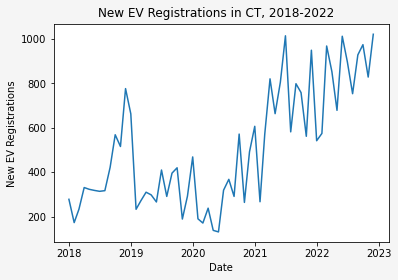

In [26]:
# Create figure and axes
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

# Add plot
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped["VEH_COUNT"])
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Create title
fig.suptitle("New EV Registrations in CT, 2018-2022", y = 0.94)

# Show
plt.show()

## Prepare dummy variables for month fixed effects

In [46]:
# Create a month column
ev_sales_zip_grouped["month"] = ev_sales_zip_grouped["date"].astype(str).str[5:7]

# Get month dummies and append these columns to the data frame
month_dummy = pd.get_dummies(ev_sales_zip_grouped["month"], prefix='month')
ev_sales_zip_grouped_dummies = pd.concat([ev_sales_zip_grouped, month_dummy], axis = 1)

# Drop the month column now
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["month"])]

# Drop the index column and call it time, which runs from 0-60
ev_sales_zip_grouped_dummies= ev_sales_zip_grouped_dummies.reset_index()
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.rename(columns = {"index":"time"})

# Drop date
ev_sales_zip_grouped_dummies = ev_sales_zip_grouped_dummies.iloc[:, ~ev_sales_zip_grouped_dummies.columns.isin(["date"])]

# Show
ev_sales_zip_grouped_dummies.head(3)

,time,VEH_COUNT,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,0,278,1,0,0,0,0,0,0,0,0,0,0,0
1,1,173,0,1,0,0,0,0,0,0,0,0,0,0
2,2,233,0,0,1,0,0,0,0,0,0,0,0,0


## Linear model with seasonality

In this step we model the data as a linear process, where:
$$
y_t = m_t + s_t+ \epsilon_t
$$
Where:
* $y_t$ is the observation of EV sales for a given month $t$
* $m_t$ is a trend component that we expect to be positive
* $s_t$ is a seasonal component
* $\epsilon t$ is a random noise component that we expect to be stationary.

More specifically, we expect that $m_t$, the seasonal component, is equal to $\beta t$, that is, to the time period (from 0-60) multiplied by some constant parameter. This indicates the expectation of a linear trend.

To model the seasonal component $s_t$, we use *fixed effects* (e.g. a fixed effect for the month of January, the month of February, etc.). This reflects an expectation that underlying data-generating process is affected by month-level seasonality (that does not change from year to year)

***

### Set up regression formula

In [47]:
y_var_name = "VEH_COUNT"
x_var_name = "time"
dummies = '+'.join([column_name for column_name in ev_sales_zip_grouped_dummies.columns.to_list()[3:]])
form = y_var_name+"~"+x_var_name+"+"+dummies
form

'VEH_COUNT~time+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

### Estimate

In [40]:
lsdv_model = smf.ols(formula=form, data=ev_sales_zip_grouped_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     6.394
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.49e-06
Time:                        06:43:11   Log-Likelihood:                -391.11
No. Observations:                  60   AIC:                             808.2
Df Residuals:                      47   BIC:                             835.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    182.9228     44.267      4.132      0.0

In [53]:
# Get predictions
predictions = lsdv_model_results.predict(ev_sales_zip_grouped_dummies)

# Get errors
errors = ev_sales_zip_grouped_dummies["VEH_COUNT"].to_list() - predictions

### Plot predicted 

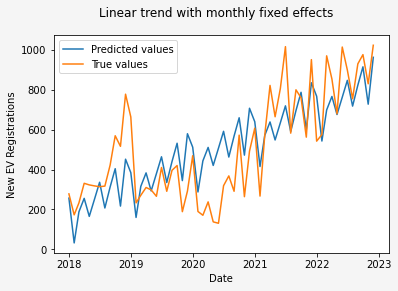

In [77]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Plot and add axes
ax.plot(ev_sales_zip_grouped["date"], predictions, label = 'Predicted values')
ax.plot(ev_sales_zip_grouped["date"], ev_sales_zip_grouped_dummies["VEH_COUNT"], label = 'True values')
ax.set_xlabel("Date")
ax.set_ylabel("New EV Registrations")

# Add legend
ax.legend(loc= 'best')

# Add title
plt.suptitle("Linear trend with monthly fixed effects")

# Show
plt.show()

### Observe errors

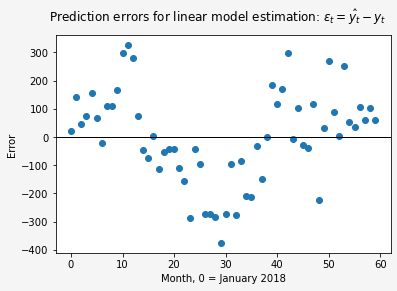

In [73]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, facecolor = 'whitesmoke')

# Add errors and a line to show 0
ax.plot(errors, marker = 'o', linestyle = 'none')
ax.axhline(0, color = 'black', linewidth = 1)

# Add x and y axis labels
ax.set_xlabel("Month, 0 = January 2018")
ax.set_ylabel("Error")

# Add figure title
fig.suptitle("Prediction errors for linear model estimation: $\epsilon_t = \hat{y_t} - y_t$")

# show
plt.show()

**Discussion:** Initial observation suggests that the plotted errors are not evenly distributed around 0. This may be an artefact of the data itself (a significant spike in EV registrationsin 2019, and a large dip in 2020 during the COVID-19 pandemic). Note: The reason for the spike in EV registrations at the beginning of 2019 is unclear.

**Possible approaches**
* Clip data before 2020 (significant loss of data, not recommended)
* Incorporate COVID pandemic in model (e.g. # of deaths from the pandemic by month, or some other direct incorporation into the model.

### Observe Autocorrelation Function (ACF) for errors.

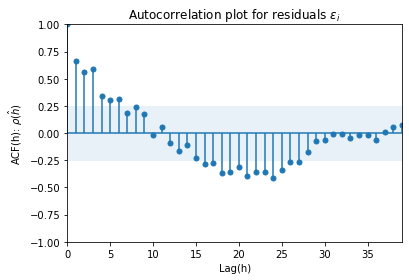

In [132]:
# Create plot
fig, ax = plt.subplots(nrows =1, ncols =1)

# Show +/- 1.96 standard deviations
upper_bound = 1.96/np.sqrt(len(ev_sales_zip_grouped))
lower_bound = -1.96/np.sqrt(len(ev_sales_zip_grouped))
ax.fill_between(np.arange(40), lower_bound, upper_bound, alpha = 0.1)
ax.set_xlim((0,39))
ax.set_xlabel("Lag(h)")
ax.set_ylabel(r"ACF(h): $\hat{\rho(h)}$")

# Show autocorrelation plot
plot_acf(errors,ax=ax,lags = np.arange(40), alpha = None,
        title = "Autocorrelation plot for residuals $\epsilon_i$")

# Show
plt.show()

Again, the sample autocorrelation functions calculated for lags from 0-40 suggest non-stationarity of the series. 

For IID Noise, the sample Autocorrelations should be approximately $\sim N(0,1/n)$ for $n$ sufficiently large. As a consequence, we would expect to see 95% of the observations fall within $\pm 1.96$ standard deviations of 0 (Brockwell and Davis 2016, pp.16-17). This would suggest only two values outside of this range.

However, we observe around 15 values outside of $\pm 1.96$ standard deviations of 0. This again suggests non-stationarity of the series.


In [95]:
fake_years = [2018, 2019, 2020, 2021, 2022,2023, 2024, 2025, 2026,2027,2028,2029,2030]
fake_months = [1,2,3,4,5,6,7,8,9,10,11,12]
fake_data = pd.DataFrame([])
i = 0
for year in fake_years:
    for month in fake_months:
        fake_data.loc[i, "year"] = int(year)
        fake_data.loc[i, "month"] = f"{int(month)}".zfill(2)
        fake_data.loc[i, "time"] = int(i)
        i+=1

In [96]:
fake_month_dummies = pd.get_dummies(fake_data["month"], prefix = 'month')
fake_data = pd.concat([fake_data, fake_month_dummies], axis = 1)
fake_data

,year,month,time,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,2018.0,01,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018.0,02,1.0,0,1,0,0,0,0,0,0,0,0,0,0
2,2018.0,03,2.0,0,0,1,0,0,0,0,0,0,0,0,0
3,2018.0,04,3.0,0,0,0,1,0,0,0,0,0,0,0,0
4,2018.0,05,4.0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2030.0,08,151.0,0,0,0,0,0,0,0,1,0,0,0,0
152,2030.0,09,152.0,0,0,0,0,0,0,0,0,1,0,0,0
153,2030.0,10,153.0,0,0,0,0,0,0,0,0,0,1,0,0
154,2030.0,11,154.0,0,0,0,0,0,0,0,0,0,0,1,0


In [97]:
b = lsdv_model_results.predict(fake_data)
b

0       256.816667
1        32.616667
2       188.216667
3       255.616667
4       165.416667
          ...     
151    1737.316667
152    1842.316667
153    1933.916667
154    1746.916667
155    1981.516667
Length: 156, dtype: float64

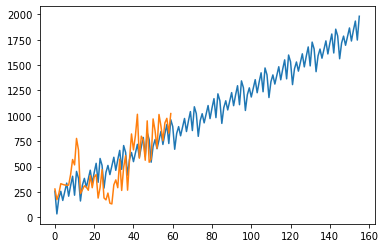

In [100]:
plt.plot(b)
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [101]:
b.sum()

159361.80000000008

## Do this with quadratic term

In [103]:
ev_sales_zip_grouped_dummies["time2"] = ev_sales_zip_grouped_dummies["time"]**2

In [105]:
form_2 = y_var_name+"~"+x_var_name+"+time2""+"+dummies
form_2

'VEH_COUNT~time+time2+month_01+month_02+month_03+month_04+month_05+month_06+month_07+month_08+month_09+month_10+month_11+month_12'

In [106]:
lsdv_model_2 = smf.ols(formula=form_2, data=ev_sales_zip_grouped_dummies)
lsdv_model_results_2 = lsdv_model_2.fit()
print(lsdv_model_results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              VEH_COUNT   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     9.539
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           3.70e-09
Time:                        15:56:15   Log-Likelihood:                -380.93
No. Observations:                  60   AIC:                             789.9
Df Residuals:                      46   BIC:                             819.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    355.7185     55.070      6.459      0.0

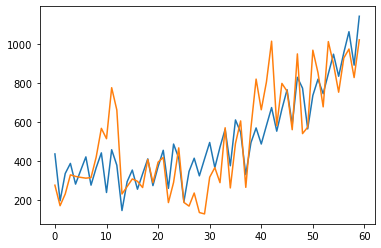

In [110]:
plt.plot(lsdv_model_results_2.predict(ev_sales_zip_grouped_dummies))
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [111]:
fake_data["time2"]=fake_data["time"]**2

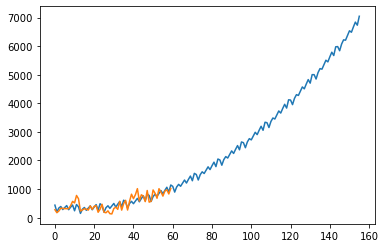

In [112]:
plt.plot(lsdv_model_results_2.predict(fake_data))
plt.plot(ev_sales_zip_grouped_dummies["VEH_COUNT"])

In [113]:
lsdv_model_results_2.predict(fake_data).sum()

365810.2557368327

So this gets us closer to the 500,000 predicted by DEEP